# Fidelity-Interpretability analysis on the MNIST dataset.

In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('once')

from utils.plotting import *

%matplotlib inline

/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/thanos/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])


Load the baseline and the logs.

In [2]:
# Baseline
baseline_loc = '../results/mnist/seeker/final/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

# Deterministic
experiment_dir = '../logs/mnist/hns/deterministic/full_training_10/'
det_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)

# ST
experiment_dir = '../logs/mnist/hns/stochastic/st1/full_training_10/'
st1_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)

# SA-1.0
experiment_dir = '../logs/mnist/hns/stochastic/sa/rate_1.0/full_training_10/'
sa_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)

det = pd.concat(det_epoch_logs)
st1 = pd.concat(st1_epoch_logs)
sa = pd.concat(sa_epoch_logs)

W0311 10:42:28.101659 139976958338816 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Baseline accuracy: 98.85%


Initially we'll plot the Fidelity of the models.

(this might take a minute)

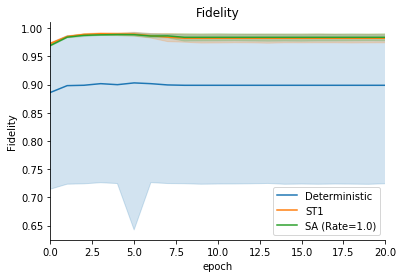

In [3]:
sns.lineplot(x='step', y='Fidelity', data=det, label='Deterministic')
sns.lineplot(x='step', y='Fidelity', data=st1, label='ST1')
sns.lineplot(x='step', y='Fidelity', data=sa, label='SA (Rate=1.0)')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Fidelity')

plt.xlim([0, 20])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

One or more collapses are evident in the "deterministic" case, where these are dragging down the models' mean performance. 

Now, let's check the Interpretability of the models.

(this might take a minute)

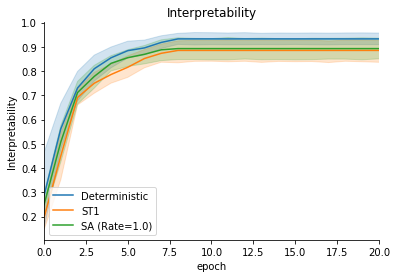

In [4]:
sns.lineplot(x='step', y='Interpretability', data=det, label='Deterministic')
sns.lineplot(x='step', y='Interpretability', data=st1, label='ST1')
sns.lineplot(x='step', y='Interpretability', data=sa, label='SA (Rate=1.0)')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('Interpretability')

plt.xlim([0, 20])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

The Interpretability seems a bit higher in the "deterministic" case.

Plot the Fidelity-to-Interpretability Ratio (FIR) of the models.

(this might take a minute)

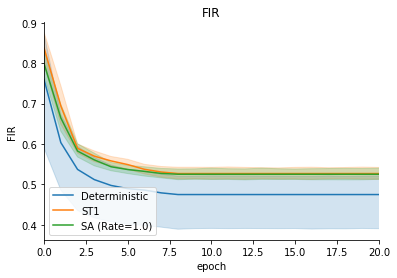

In [5]:
sns.lineplot(x='step', y='FIR', data=det, label='Deterministic')
sns.lineplot(x='step', y='FIR', data=st1, label='ST1')
sns.lineplot(x='step', y='FIR', data=sa, label='SA (Rate=1.0)')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('FIR')

plt.xlim([0, 20])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Notice how these models start from a high FIR value, indicating that they learn to classify much faster than they learn to "hide" pixels (this is the result of the adaptive weighting of the two loss terms). 

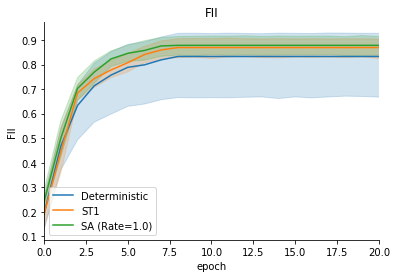

In [6]:
sns.lineplot(x='step', y='FII', data=det, label='Deterministic')
sns.lineplot(x='step', y='FII', data=st1, label='ST1')
sns.lineplot(x='step', y='FII', data=sa, label='SA (Rate=1.0)')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('FII')

plt.xlim([0, 20])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Finally, the FII seems to improve and converge to a peak value as training progresses.

Let's see which thresholding technique has the best FII.

In [7]:
print('Peak FII (Det.): {:.2f}%'.format(det['FII'].max()* 100))
print('Peak FII (ST1.): {:.2f}%'.format(st1['FII'].max()* 100))
print('Peak FII (SA.):  {:.2f}%'.format(sa['FII'].max()* 100))

Peak FII (Det.): 97.31%
Peak FII (ST1.): 95.77%
Peak FII (SA.):  94.83%


Check the results for the deterministic model (i.e. the best one).

In [8]:
best_epoch = det['FII'].idxmax()
print('Best Fidelity:         {:.2f}%'.format(det['Fidelity'].iloc[best_epoch] * 100))
print('Best Interpretability: {:.2f}%'.format(det['Interpretability'].iloc[best_epoch] * 100))
print('Best FIR:              {:.2f}%'.format(det['FIR'].iloc[best_epoch]))

Best Fidelity:         98.25%
Best Interpretability: 95.37%
Best FIR:              0.51%


Build the final plot.

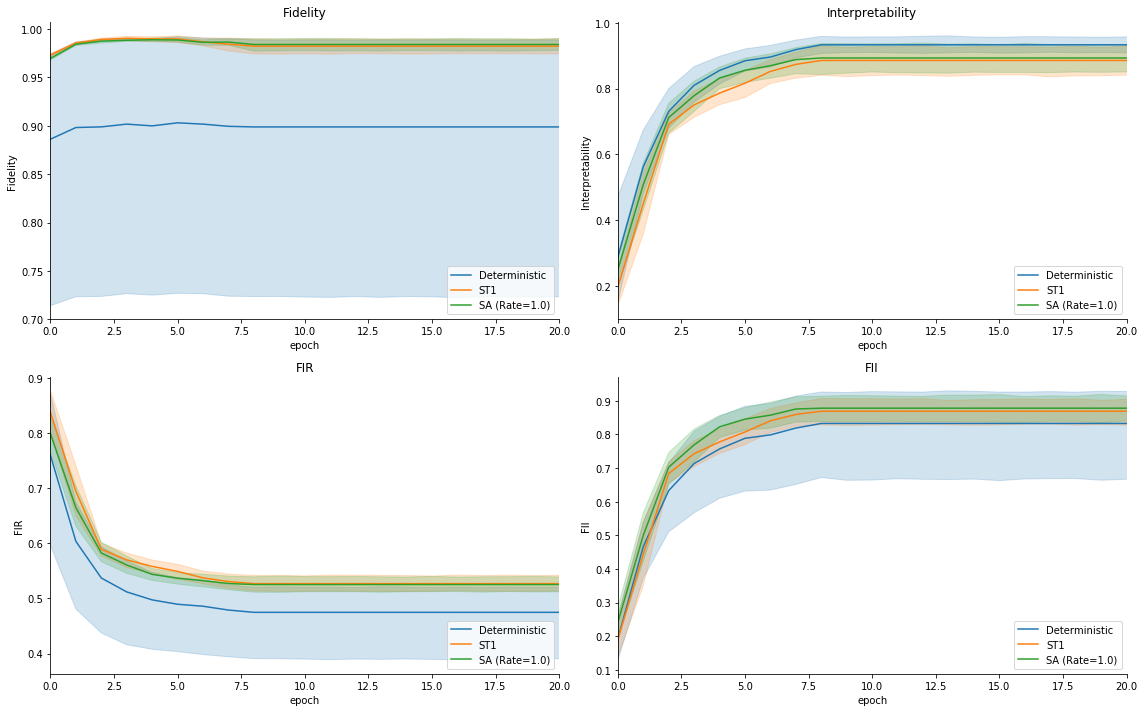

In [9]:
plt.figure(figsize=(16, 10))

ax = plt.subplot(221)

sns.lineplot(x='step', y='Fidelity', data=det, label='Deterministic', ax=ax)
sns.lineplot(x='step', y='Fidelity', data=st1, label='ST1', ax=ax)
sns.lineplot(x='step', y='Fidelity', data=sa, label='SA (Rate=1.0)', ax=ax)

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Fidelity')

plt.xlim([0, 20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(222)

sns.lineplot(x='step', y='Interpretability', data=det, label='Deterministic', ax=ax)
sns.lineplot(x='step', y='Interpretability', data=st1, label='ST1', ax=ax)
sns.lineplot(x='step', y='Interpretability', data=sa, label='SA (Rate=1.0)', ax=ax)

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Interpretability')

plt.xlim([0, 20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(223)

sns.lineplot(x='step', y='FIR', data=det, label='Deterministic', ax=ax)
sns.lineplot(x='step', y='FIR', data=st1, label='ST1', ax=ax)
sns.lineplot(x='step', y='FIR', data=sa, label='SA (Rate=1.0)', ax=ax)

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('FIR')

plt.xlim([0, 20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(224)

sns.lineplot(x='step', y='FII', data=det, label='Deterministic', ax=ax)
sns.lineplot(x='step', y='FII', data=st1, label='ST1', ax=ax)
sns.lineplot(x='step', y='FII', data=sa, label='SA (Rate=1.0)', ax=ax)

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('FII')

plt.xlim([0, 20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/mnist_results.pdf', bbox_inches='tight')

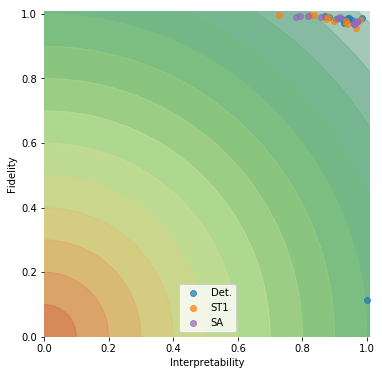

In [10]:
plt.figure(figsize=(6, 6))

fidelity_interpretability_projection([det_epoch_logs, st1_epoch_logs, sa_epoch_logs],
                                     baseline, 
                                     labels=['Det.', 'ST1', 'SA'],
                                     colors=['C0', 'C1', 'C4'],
                                     max_fii=False)

plt.savefig('figures/mnist_2d.pdf', bbox_inches='tight')

## Best model

We consider the best model to be the one that scored the highest FII. Find the best thresholding.

In [11]:
print('Best det FII:', np.max([np.max(log['FII']) for log in det_epoch_logs]))
print('Best ST1 FII:', np.max([np.max(log['FII']) for log in st1_epoch_logs]))
print('Best SA FII: ', np.max([np.max(log['FII']) for log in sa_epoch_logs]))

Best det FII: 0.973096489906311
Best ST1 FII: 0.9577167630195618
Best SA FII:  0.9483014345169067


Print its stats.

In [12]:
best_model = np.argmax([np.max(log['FII']) for log in det_epoch_logs])
best_fii = np.argmax(det_epoch_logs[best_model]['FII'].values)
det_epoch_logs[best_model].iloc[[best_fii]]

,Average loss per epoch,FII,FIR,Fidelity,Interpretability,Validation accuracy,step
8,0.023304,0.973096,0.500955,0.988342,0.984574,0.976953,8
